In [1]:
!pip install -q efficientnet >> /dev/null

In [2]:
import os, glob
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, save_img,img_to_array
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

In [3]:
SEED = 42
EPOCHS = 1
BATCH_SIZE = 32
IMG_HEIGHT = 400
IMG_WIDTH = 400

IMG_ROOT = '/content/drive/MyDrive/Project/dataset/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal', 
           IMG_ROOT+'2_cataract', 
           IMG_ROOT+'2_glaucoma', 
           IMG_ROOT+'3_retina_disease']

OCU_IMG_ROOT = '/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K/Training Images/'
ocu_df = pd.read_excel('/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K/data.xlsx')


In [4]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [ ]:
cat_df = pd.DataFrame(0, columns=['paths','cataract'],index=range(601))

filepaths = glob.glob(IMG_ROOT + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    if filepath[0] == IMG_DIR[0]:    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == IMG_DIR[2]:  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == IMG_DIR[3]:  # retine_disease
        cat_df.iloc[i, 1] = 3
        
# only sample normal and cataract        
cat_df = cat_df.query('0 <= cataract < 2')
cat_df

,paths,cataract
0,/content/drive/MyDrive/Project/dataset/dataset...,0
1,/content/drive/MyDrive/Project/dataset/dataset...,0
2,/content/drive/MyDrive/Project/dataset/dataset...,0
3,/content/drive/MyDrive/Project/dataset/dataset...,0
4,/content/drive/MyDrive/Project/dataset/dataset...,0
...,...,...
395,/content/drive/MyDrive/Project/dataset/dataset...,1
396,/content/drive/MyDrive/Project/dataset/dataset...,1
397,/content/drive/MyDrive/Project/dataset/dataset...,1
398,/content/drive/MyDrive/Project/dataset/dataset...,1


In [ ]:
#cat_df.to_csv('/content/drive/MyDrive/Project/cat.csv')

In [ ]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())

Number of normal and cataract images
0    300
1    100
Name: cataract, dtype: int64


In [ ]:
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [ ]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    elif 'normal fundus' in text:
        return 0
    
ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))

In [ ]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']]\
        .rename(columns={'left_eye_cataract':'cataract'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']]\
        .rename(columns={'right_eye_cataract':'cataract'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [ ]:
le_df=le_df.dropna()
le_df['cataract']=le_df['cataract'].astype(int)
le_df.head()

,cataract,paths
0,1,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...
1,0,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...
3,0,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...
8,0,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...
9,0,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...


In [ ]:
re_df=re_df.dropna()
re_df['cataract']=re_df['cataract'].astype(int)
re_df.head()

,cataract,paths
0,0,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...
1,0,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...
8,0,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...
10,0,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...
20,0,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...


In [ ]:
print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
0    1580
1     159
Name: cataract, dtype: int64

Number of right eye images
0    1518
1     154
Name: cataract, dtype: int64


In [ ]:
def downsample(df):
    df = pd.concat([
        df.query('cataract==1.0'),
        df.query('cataract==0.0').sample(sum(df['cataract']), 
                                       random_state=SEED)
    ])
    return df


le_df = downsample(le_df)
re_df = downsample(re_df)

print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
1    159
0    159
Name: cataract, dtype: int64

Number of right eye images
1    154
0    154
Name: cataract, dtype: int64


In [ ]:
ocu_df = pd.concat([le_df, re_df])
ocu_df.head()

,cataract,paths
0,1,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...
81,1,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...
103,1,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...
119,1,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...
253,1,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...


In [ ]:
ocu_df.shape

(626, 2)

In [ ]:
df = pd.concat([cat_df, ocu_df], ignore_index=True)
df

,paths,cataract
0,/content/drive/MyDrive/Project/dataset/dataset...,0
1,/content/drive/MyDrive/Project/dataset/dataset...,0
2,/content/drive/MyDrive/Project/dataset/dataset...,0
3,/content/drive/MyDrive/Project/dataset/dataset...,0
4,/content/drive/MyDrive/Project/dataset/dataset...,0
...,...,...
1021,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...,0
1022,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...,0
1023,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...,0
1024,/content/drive/MyDrive/Project/ODIR-5K/ODIR-5K...,0


In [ ]:
#df.to_csv('/content/drive/MyDrive/Project/df.csv')

In [ ]:
train_df, test_df= train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [5]:
def preprocessingImage(image):
    test_img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    test_img_gray = cv.cvtColor(test_img, cv.COLOR_RGB2GRAY)
    test_img_thresh = cv.adaptiveThreshold(test_img_gray,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,11,3)
    cnts = cv.findContours(test_img_thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv.contourArea, reverse=True)
    for c in cnts:
        x,y,w,h = cv.boundingRect(c)
        test_img_ROI = test_img[y:y+h, x:x+w]
        break
    test_img_ROI_resize = cv.resize(test_img_ROI, (IMG_WIDTH, IMG_HEIGHT))
    test_img_ROI_resize_gray = cv.cvtColor(test_img_ROI_resize, cv.COLOR_RGB2GRAY)
    
    return test_img_ROI_resize_gray

In [ ]:
#def create_datasets(df,img_width,img_height):
 # imgs=[]
  #for path in tqdm(df['paths']):
   # for i in range(1,1027)
    #img=cv.imread(path)
    #img=preprocessingImage(img)
    #cv.imwrite('/content/drive/MyDrive/Project/preprocessed_images/')
  #imgs=np.array(imgs,dtype='float32')
  #df1=pd.get_dummies(df['cataract'])
  #return imgs,df1

#train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
#val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
#test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

#train_imgs = train_imgs / 255.0
#val_imgs = val_imgs / 255.0
#test_imgs = test_imgs / 255.0    

In [ ]:
def show_image(img, cmap='gray'):
    fig = plt.figure(figsize=(20,20))
    axes = fig.add_subplot(111)
    axes.imshow(img, cmap=cmap)

In [ ]:
tr=[]
for path in tqdm(df['paths']):
  tr.append(path)
i=cv.imread(tr[3])
#print(i)
i = preprocessingImage(i)
i=img_to_array(i)
save_img('/content/drive/MyDrive/Project/trial.png',i)
#show_image(i)

100%|██████████| 1026/1026 [00:00<00:00, 854179.42it/s]


In [ ]:
i=[]
tr=[]
for path in tqdm(df['paths']):
  tr.append(path)

100%|██████████| 1026/1026 [00:00<00:00, 523140.76it/s]


In [ ]:
train=[]
for t in tqdm(tr[0:10]):
  for i in range(1,11):
    img = cv.imread(t)
    img = preprocessingImage(img)
    train.append(img)
    #cv.imwrite('/content/drive/MyDrive/Project/preprocessed_images/'+str((i))+'.png',img)

100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


In [ ]:
train_normal='/content/drive/MyDrive/Project/dataset/dataset/1_normal/'
train_cataract='/content/drive/MyDrive/Project/dataset/dataset/2_cataract/'


In [ ]:
for file in range(1,101):
    image = cv.imread(f'{train_cataract}/cataract_{str(file).zfill(3)}.png')
    img = preprocessingImage(image)
    #t_cataract.append(img)
    cv.imwrite('/content/drive/MyDrive/Project/preprocessed_images/CAT_'+str((file))+'.png',img)

In [ ]:
for file in range(1,301):
    image = cv.imread(f'{train_normal}/NL_{str(file).zfill(3)}.png')
    img = preprocessingImage(image)
    cv.imwrite('/content/drive/MyDrive/Project/preprocessed_images/NL_'+str((file))+'.png',img)

In [ ]:
cat=ocu_df[ocu_df['cataract']==1]

In [ ]:
nl=ocu_df[ocu_df['cataract']==0]

In [ ]:
i=101
for c in tqdm(cat['paths']):
  img=cv.imread(c)
  img=preprocessingImage(img)
  cv.imwrite('/content/drive/MyDrive/Project/preprocessed_images/cataract/CAT_'+str((i))+'.jpg',img)
  i+=1

100%|██████████| 313/313 [00:50<00:00,  6.14it/s]


In [ ]:
i=301
for n in tqdm(nl['paths']):
  img=cv.imread(n)
  img=preprocessingImage(img)
  cv.imwrite('/content/drive/MyDrive/Project/preprocessed_images/normal/NL_'+str((i))+'.jpg',img)
  i+=1

100%|██████████| 313/313 [00:44<00:00,  7.06it/s]


In [ ]:
def pI(image):
    test_img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    test_img_gray = cv.cvtColor(test_img, cv.COLOR_RGB2GRAY)
    test_img_thresh = cv.adaptiveThreshold(test_img_gray,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,11,3)
    cnts = cv.findContours(test_img_thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv.contourArea, reverse=True)
    for c in cnts:
        x,y,w,h = cv.boundingRect(c)
        test_img_ROI = test_img[y:y+h, x:x+w]
        break
    test_img_ROI_resize = cv.resize(test_img_ROI, (1600, 1600))
    test_img_ROI_resize_gray = cv.cvtColor(test_img_ROI_resize, cv.COLOR_RGB2GRAY)
    
    return test_img_ROI_resize_gray

In [ ]:
CAT=df[df['cataract']==1]
NL=df[df['cataract']==0]

In [ ]:
i=1
for n in tqdm(NL['paths']):
  img=cv.imread(n)
  img=preprocessingImage(img)
  cv.imwrite('/content/drive/MyDrive/Project/preprocessed_images_2/normal/NL_'+str((i))+'.png',img)
  i+=1

100%|██████████| 613/613 [04:22<00:00,  2.33it/s]


In [ ]:
i=1
for c in tqdm(CAT['paths']):
  img=cv.imread(c)
  img=preprocessingImage(img)
  cv.imwrite('/content/drive/MyDrive/Project/preprocessed_images_2/cataract/CAT_'+str((i))+'.png',img)
  i+=1

100%|██████████| 413/413 [01:55<00:00,  3.57it/s]


In [6]:
img_root='/content/drive/MyDrive/Project/preprocessed_images/'
img_dir=[img_root+'normal',
         img_root+'cataract']

In [7]:
df_pr = pd.DataFrame(0, 
                  columns=['paths', 
                           'cataract'],
                  index=range(1026))

filepaths = glob.glob(img_root + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    df_pr.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    if filepath[0] == img_dir[0]:    # normal
        df_pr.iloc[i, 1] = 0
    elif filepath[0] == img_dir[1]:  # cataract
        df_pr.iloc[i, 1] = 1

In [8]:
df_pr.head(10)

,paths,cataract
0,/content/drive/MyDrive/Project/preprocessed_im...,1
1,/content/drive/MyDrive/Project/preprocessed_im...,1
2,/content/drive/MyDrive/Project/preprocessed_im...,1
3,/content/drive/MyDrive/Project/preprocessed_im...,1
4,/content/drive/MyDrive/Project/preprocessed_im...,1
5,/content/drive/MyDrive/Project/preprocessed_im...,1
6,/content/drive/MyDrive/Project/preprocessed_im...,1
7,/content/drive/MyDrive/Project/preprocessed_im...,1
8,/content/drive/MyDrive/Project/preprocessed_im...,1
9,/content/drive/MyDrive/Project/preprocessed_im...,1


In [9]:
#df_pr.to_csv('/content/drive/MyDrive/Project/preprocessed_images/df_pr.csv')

In [10]:
train_df, test_df = train_test_split(df_pr, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df_pr['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [13]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv.imread(path)
        img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        img = cv.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|██████████| 206/206 [01:21<00:00,  2.53it/s]


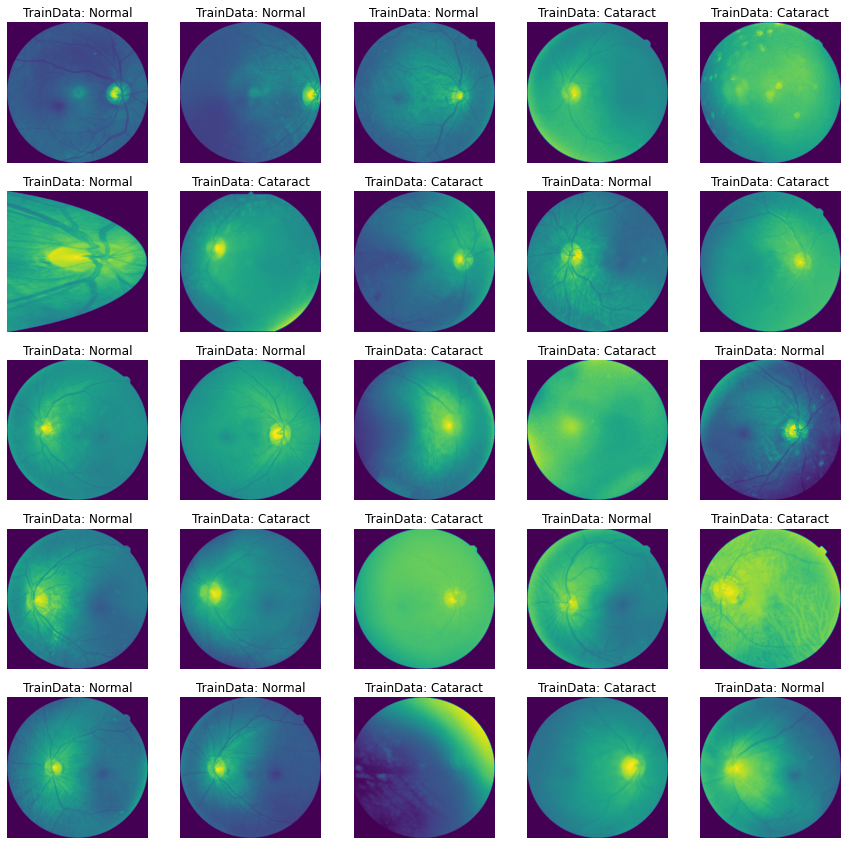

In [14]:
# plot the first 25 sheets of image data for Train
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.show()

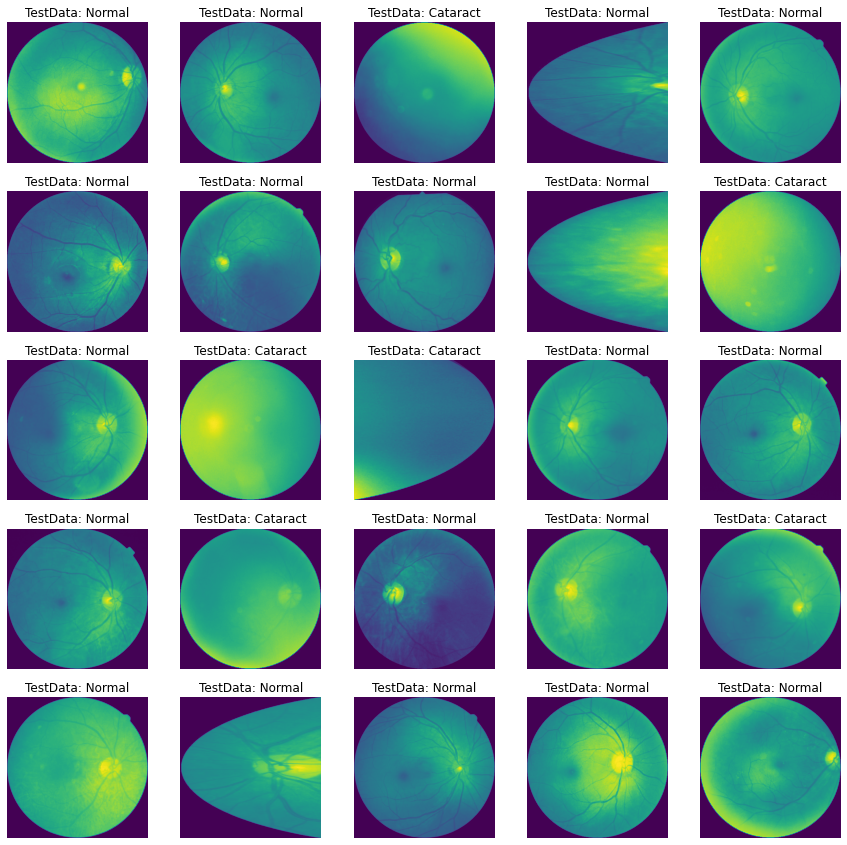

In [15]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

In [16]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
get_custom_objects().update({'mish': Activation(mish)})

In [19]:
input_shape = (IMG_HEIGHT, IMG_WIDTH,3)

model = Sequential()
model.add(Conv2D(16, kernel_size=3, padding='same', 
                 input_shape=input_shape, activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 400, 400, 16)      448       
                                                                 
 conv2d_6 (Conv2D)           (None, 400, 400, 16)      2320      
                                                                 
 batch_normalization_2 (Batc  (None, 400, 400, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 133, 133, 16)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 133, 133, 16)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 133, 133, 16)     

In [24]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 


#generator.fit(train_imgs.reshape(697,400,400,1))
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

In [32]:
#tri=train_imgs.reshape(697,400,400,1)
#vi=val_imgs.reshape(123,400,400,1)
#vi.shape

(123, 400, 400, 1)

In [34]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df)
                                   #,batch_size=BATCH_SIZE), 
                    ,epochs=10,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr]
                    ,validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
model.evaluate(test_imgs, test_df)

7/7 [==============================] - 32s 4s/step - loss: 0.7955 - accuracy: 0.6117


[0.7954845428466797, 0.6116504669189453]

In [ ]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 efficientnet-b0 (Functional  (None, 13, 13, 1280)     4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

In [ ]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=5,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

Epoch 1/5
